# Capstone Project - The Battle of Neighborhoods

## Supporting the opening of a new italian restaurant in NYC with a data-driven approach

### Question: Where would you locate the new activity, to have the best customer base in terms of size and quality avoiding high-level of competition?

Mister X is going to open a new Italian Restaurant in NYC and he is really worried about the choice of the location. He decides to ask for a data driven approach to support his decision.
Since I want to demonstrate my skills as data scientist, I decided to help him solving this problem. To do this, it is necessary to follow a step-by-step approach which could be divided in 2 phases:
- **Top-down phase** - *from real problem to data analysis: note that this phase could be repeated in a loop until the business question is compatible with data availability*
    - Problem Setting and Business Requirements: Definition of the question to be answered through data
    - Data Assessment: Understanding of what data could be useful for answering the question
    - Data Availability checks and Data Analysis design: Checking data availability and quality and definition of the technical steps for the solution.
- **Bottom-down phase** - *from data analysis to real answers*:
    - Data Analysis: Application of Data Science concepts and tools for the analysis of data
    - Results Evaluation: Understanding of the results and choice of the final answer to the problem 
    - Story Telling: Collection of the best data visualization reports/dashboards and full description of the approach driving the answer. The final report has to be clear, precise and effective.
    
In the following sections, each phase will be explained in detail.

## Top-down phase

### Problem setting
Understanding the neighborhoods of NYC in terms of population and category of commercial activities, to define the best neighorhood to place an italian restaurant.
The answer should find a neighborhood balancing the following principles:
- Maximum number of Italian Restaurants: this ensures that in the neighborhood the italian cuisine is really appreciated
- Highest average salary: this ensures that a lot of people would be able to spend their money in the restaurant
- Highest size of population: this ensures that a lot of people could enter in the restaurant and talk about it around the city
- Lowest average rate of Competitors: this ensures that the level of competition will be not so hard

### Data Assessment
For this problem we would need 2 groups of information:
- Geographic data: information of latitude and longitude of neighborhoods
- Demographic data: information of population size and average salary by neighborhood in NYC
- Restaurants data: information of number, category and rates of the restaurants by neighborhoods in NYC

### Data Availability
I checked the availability of data and I have found 2 datasets which could satify my needings:
- Geographic data: this is available in a JSON file of the course I am attending, through the link https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json 
- Demographic data: this is retrieved on https://www1.nyc.gov/ and https://www.census.gov/. I have downloaded different dataset and merged them into a unique .csv file
- Restaurants data: we can extract them from Foursquare database https://foursquare.com/

### Data Analysis Design
The problem can be faced as a clustering problem, using the K-Means algorithm.
We have to scrape data from Foursquare and upload the CSV with census data, merge them into a unique DataFrame and prepare the data for the model
We could define k clusters and classify them in terms of the 4 principle/variables defined in the first phase: Density of Italian Restaurants, Average Salary, Size of population,  Average Rate of competitors.
In this way we could give a clear knowledge to Mister X of the pros and cons of each area so that he can decide the neighborhood based on the trade-off between advantages and challenges.

## Top-down phase

### Data Analysis

Let's start with the data collection and cleaning. We need 3 dataset:
- geo_df: geographic data. 4 columns: Borough, Neighborhood, Latitude, Longitude
- demo_df: demographic data. 4 columns: Borough, Population, IncomePerCap
- rest_df: restaurants data. 4 Columns: Id, Latitude, Longitude, Category, Rate

In [1]:
#importing libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import preprocessing

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

from project_lib import Project #for CSV uploading from Project

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


### geo_df

In [2]:
#geo_df
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
geo_df = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    geo_df = geo_df.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
geo_df.groupby(by='Borough').agg('count')['Neighborhood']

Data downloaded!


Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

In [3]:
#Visualization of the map of neighborhoods

address = 'New York City, NY'


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

color = {'Bronx':'red', 'Brooklyn':'blue', 'Manhattan':'green', 'Queens':'yellow', 'Staten Island':'grey'}
# add markers to map
for lat, lng, borough, neighborhood in zip(geo_df['Latitude'], geo_df['Longitude'], geo_df['Borough'], geo_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color[borough],
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)

boroughs = [('Bronx','Bronx,New York City, NY'),('Brooklyn','Brooklyn,New York City, NY'),('Manhattan','Manhattan,New York City, NY'),('Queens','Queens,New York City, NY'), ('Staten Island','Staten Island,New York City, NY')]
color = {'Bronx':'red', 'Brooklyn':'blue', 'Manhattan':'green', 'Queens':'yellow', 'Staten Island':'grey'}
boroughs_df = pd.DataFrame(columns = ['Borough','Latitude','Longitude','Color'])
for name,address in boroughs:
    location = geolocator.geocode(address)
    series = pd.Series([name,location.latitude, location.longitude,color[name]],index=boroughs_df.columns)
    boroughs_df = boroughs_df.append(series, ignore_index=True)   

for lat, lng, borough,color in zip(boroughs_df['Latitude'], boroughs_df['Longitude'], boroughs_df['Borough'],boroughs_df['Color']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='black',
        weight=5,
        fill=True,
        fill_color='white',
        fill_opacity=1,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### rest_df

In [4]:
#rest_df
#Foursquare credentials
CLIENT_ID = 'CB5SAVX2QFAWUJXPGKYCLUHFOWQDKOUO0FYCOX0SSO1MAANF' # your Foursquare ID
CLIENT_SECRET = 'NTXUOAMOYNUCGMYFPXBNUMKD0PNWJ40SIHFIGEE0YBF0CSSQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CB5SAVX2QFAWUJXPGKYCLUHFOWQDKOUO0FYCOX0SSO1MAANF
CLIENT_SECRET:NTXUOAMOYNUCGMYFPXBNUMKD0PNWJ40SIHFIGEE0YBF0CSSQ


In [5]:
#let's get the venues that are in each neighborhood within a radius of 500 meters.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
ny_venues = getNearbyVenues(names=geo_df['Neighborhood'],
                                   latitudes=geo_df['Latitude'],
                                   longitudes=geo_df['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [7]:
#Let's check the resulting dataframe
print(ny_venues.shape)
ny_venues.head()

(10166, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Id,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,4c537892fd2ea593cb077a28,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,4d6af9426107f04dedeb297a,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,4c783cef3badb1f7e4244b54,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,5d5f5044d0ae1c0008f043c3,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',4c25c212f1272d7f836385c5,40.890459,-73.849089,Donut Shop


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


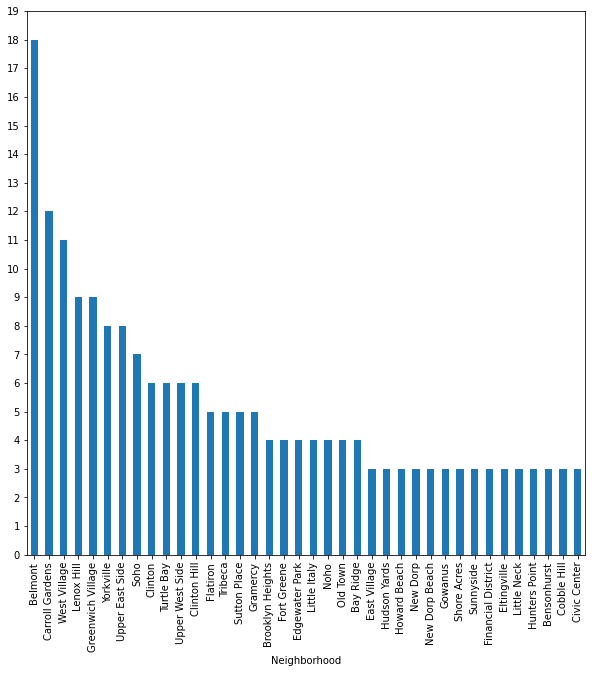

In [8]:
#Let's filter out only the italian restaurants
def filter_italian(string):
    return 'italian' in string.lower()
ny_venues = ny_venues[ny_venues['Venue Category'].apply(filter_italian)]

#Let's filter out neighborhoods with n. italian restaurants over average and check the bar plot
ny_venues_bar = ny_venues.groupby(['Neighborhood']).agg(['count'])
ny_venues_bar.reset_index(inplace=True)
ny_venues_bar.drop(['Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category'],axis=1,inplace=True)
ny_venues_bar.rename(columns={'Neighborhood Latitude':'N. italian restaurants'}, inplace=True)
ny_venues_bar.sort_values(by=('N. italian restaurants','count'),ascending=False,inplace=True)
ny_venues_bar=ny_venues_bar[ny_venues_bar[('N. italian restaurants','count')]>ny_venues_bar[('N. italian restaurants','count')].agg('mean')]
ny_venues_bar.plot.bar(x='Neighborhood',y=('N. italian restaurants','count'),legend=False,yticks=range(0,20),figsize=(10,10))



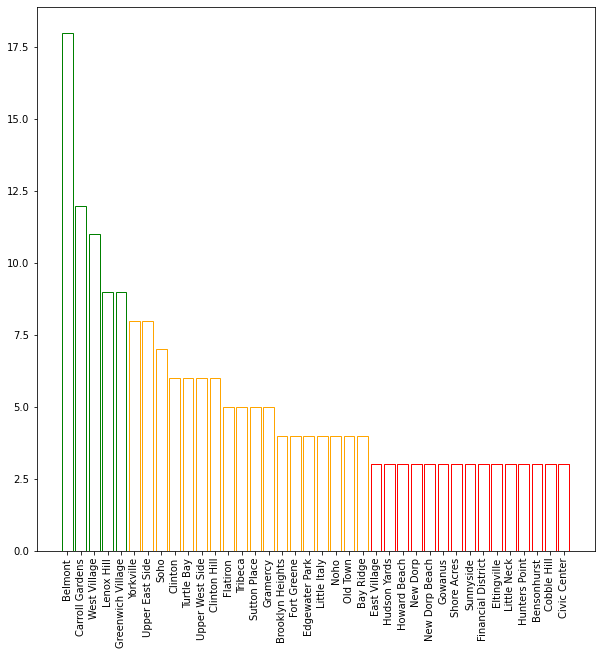

In [9]:
#We find out 3 clusters of neighborhoods -> High level (more than 8 restaurants), Mid Level (between 4 and 8 restaurants), Low Level (less than 4 restaurants)
#let's color them in the bar plot

mask1 = ny_venues_bar[('N. italian restaurants','count')] > 8
mask2 = ny_venues_bar[('N. italian restaurants','count')] >= 4
 
plt.figure(figsize=(10, 10))
plt.bar(ny_venues_bar[mask1]['Neighborhood'], ny_venues_bar[mask1][('N. italian restaurants','count')], color='white',edgecolor = 'green')
plt.bar(ny_venues_bar[mask2 & mask1==False]['Neighborhood'], ny_venues_bar[mask2 & mask1==False][('N. italian restaurants','count')], color='white',edgecolor = 'orange')
plt.bar(ny_venues_bar[mask2==False]['Neighborhood'], ny_venues_bar[mask2==False][('N. italian restaurants','count')], color='white',edgecolor = 'red')
plt.xticks(rotation=90)
plt.show()                    
                      

In [10]:
#Let's plot the map of this venues
def filter_neigh(neigh,neigh_list = list(ny_venues_bar['Neighborhood'])):
    return neigh in neigh_list

ny_venues=ny_venues[ny_venues['Neighborhood'].apply(filter_neigh)]
geo_df = geo_df[geo_df['Neighborhood'].apply(filter_neigh)]

geo_df
## create map of Manhattan using latitude and longitude values
map_ny_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(ny_venues['Venue Latitude'], ny_venues['Venue Longitude'], ny_venues['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny_venues)  
for lat, lng, neighborhood in zip(geo_df['Latitude'], geo_df['Longitude'], geo_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_ny_venues) 
map_ny_venues

In [11]:
#Let's recall our geo_df
geo_df.head()

,Borough,Neighborhood,Latitude,Longitude
34,Bronx,Belmont,40.857277,-73.888452
39,Bronx,Edgewater Park,40.821986,-73.813885
46,Brooklyn,Bay Ridge,40.625801,-74.030621
47,Brooklyn,Bensonhurst,40.611009,-73.995180
64,Brooklyn,Brooklyn Heights,40.695864,-73.993782


In [12]:
#Let's check our ny_venues
ny_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Id,Venue Latitude,Venue Longitude,Venue Category
764,Belmont,40.857277,-73.888452,Tino's Delicatessen,4acf80aef964a52025d420e3,40.855882,-73.887166,Italian Restaurant
769,Belmont,40.857277,-73.888452,Michaelangelo's Coal Fired Brick Oven Pizza Re...,4af71916f964a520cf0522e3,40.857412,-73.886468,Italian Restaurant
771,Belmont,40.857277,-73.888452,Arthur Avenue Fiasco,59050f51b23dfa5f6649e678,40.854844,-73.887908,Italian Restaurant
783,Belmont,40.857277,-73.888452,Calabria Pork Store,4bb6470cef159c7465b275f7,40.854145,-73.888776,Italian Restaurant
787,Belmont,40.857277,-73.888452,Antonio's Trattoria,4af0fa29f964a52060e021e3,40.854083,-73.886616,Italian Restaurant


In [13]:
#let's get ratings for each venue.
def getRatings(venue_ids,names):
    
    venues_list=[]
    for venue_id,name in zip(venue_ids,names):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        #print(url)   
        # make the GET request
        results = requests.get(url).json()
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([
                name,
                venue_id,
                results["response"]['venue']['rating']])
        except: venues_list.append([name,venue_id,0])
            
    venues_rating = pd.DataFrame(venues_list)
    venues_rating.columns = [
                  'Venue',
                  'Venue_Id',
                  'Rating']
   
    return(venues_rating)

In [14]:
venues_rating = getRatings(venue_ids=ny_venues['Id'],names=ny_venues['Venue'])
#venues_rating = getRatings(venue_ids=['59050f51b23dfa5f6649e678','4bb6470cef159c7465b275f7'],names=['Arthur Avenue Fiasco','Calabria Pork Store'])

Tino's Delicatessen
Michaelangelo's Coal Fired Brick Oven Pizza Restaurant
Arthur Avenue Fiasco
Calabria Pork Store
Antonio's Trattoria
Enzo's
Dominick's Restaurant
Emilia's Restaurant
Tra Di Noi
Gerbasi Ristorante
Roberto's
Mario's Restaurant & Catering
Cafe al Mercato
Pasquale Riggaletto's
David Greco's Arthur Avenue Trattoria
San Gennaro Ristorante
Ann & Tony's - An Original Arthur Avenue Restaurant
Arthur Avenue Cafe
Patricia's of Tremont
Tosca Marquee
Spoto's Italian Restaurant
Rino's Italian Restaurant
Tuscany Grill
Sofia Ristorante Italiano
Zio Toto
Zitelli's Thin Crust Pizza and Bar
Villa Fiorita
il Colosseo
Avon
River Deli
Noodle Pudding
Caffe Buon Gusto
Bevacco
Lillo
Popina
Table 87
Fragole
Vinny's of Carroll Gardens
Claudine's
Gersi
Frankies 457 Spuntino
Panzerotti Bites
Franks Wine Bar
Sociale Brooklyn
Ciros on Smith
Verde on Smith
Enoteca on Court
Marco Polo Ristorante
Frankies 457 Spuntino
Franks Wine Bar
Aperture Restaurant
Evelina Restaurant
Dino
Fradei
Roman’s
LaRina P

In [15]:
#building rest_df with borough, neighborhood rating and number of venues

#replacing 0s with average of all the other restaurants
venues_rating['Rating'].replace(0,venues_rating[venues_rating['Rating']!=0]['Rating'].mean(),inplace=True)

#renaming venue_id column
venues_rating.rename(columns={'Venue_Id':'Id'}, inplace=True)

#merging ny_venues and venues_rating
ny_venues_final = pd.merge(ny_venues[['Neighborhood','Venue','Id','Venue Latitude','Venue Longitude']],venues_rating[['Id','Rating']],on='Id',how='left')
ny_venues_final = pd.merge(ny_venues_final,geo_df,on='Neighborhood',how='left')

#Let's finalize rest_df evaluating for each Neighborhood, the average number of restaurants and the average rating
rest_df=ny_venues_final.groupby(['Neighborhood','Borough']).agg('mean')
rest_df.reset_index(inplace=True)
rest_df.drop(['Venue Latitude','Venue Longitude'], axis=1,inplace=True)
rest_df['Restaurants'] = ny_venues_final.groupby(['Neighborhood','Borough']).agg('count')['Venue'].values

rest_df.sort_values(by='Borough')

,Neighborhood,Borough,Rating,Latitude,Longitude,Restaurants
1,Belmont,Bronx,8.055556,40.857277,-73.888452,18
10,Edgewater Park,Bronx,7.225000,40.821986,-73.813885,4
0,Bay Ridge,Brooklyn,7.125000,40.625801,-74.030621,4
2,Bensonhurst,Brooklyn,7.880628,40.611009,-73.995180,3
3,Brooklyn Heights,Brooklyn,7.725000,40.695864,-73.993782,4
4,Carroll Gardens,Brooklyn,8.000000,40.680540,-73.994654,14
15,Gowanus,Brooklyn,8.540000,40.673931,-73.994441,5
7,Clinton Hill,Brooklyn,8.644444,40.693229,-73.967843,9
8,Cobble Hill,Brooklyn,8.466667,40.687920,-73.998561,3
14,Fort Greene,Brooklyn,8.785714,40.688527,-73.972906,7


,Neighborhood,Borough,Rating,Latitude,Longitude,Restaurants
1,Belmont,Bronx,8.055556,40.857277,-73.888452,18
10,Edgewater Park,Bronx,7.225000,40.821986,-73.813885,4
0,Bay Ridge,Brooklyn,7.125000,40.625801,-74.030621,4
2,Bensonhurst,Brooklyn,7.880628,40.611009,-73.995180,3
3,Brooklyn Heights,Brooklyn,7.725000,40.695864,-73.993782,4
4,Carroll Gardens,Brooklyn,8.000000,40.680540,-73.994654,14
15,Gowanus,Brooklyn,8.540000,40.673931,-73.994441,5
7,Clinton Hill,Brooklyn,8.644444,40.693229,-73.967843,9
8,Cobble Hill,Brooklyn,8.466667,40.687920,-73.998561,3
14,Fort Greene,Brooklyn,8.785714,40.688527,-73.972906,7


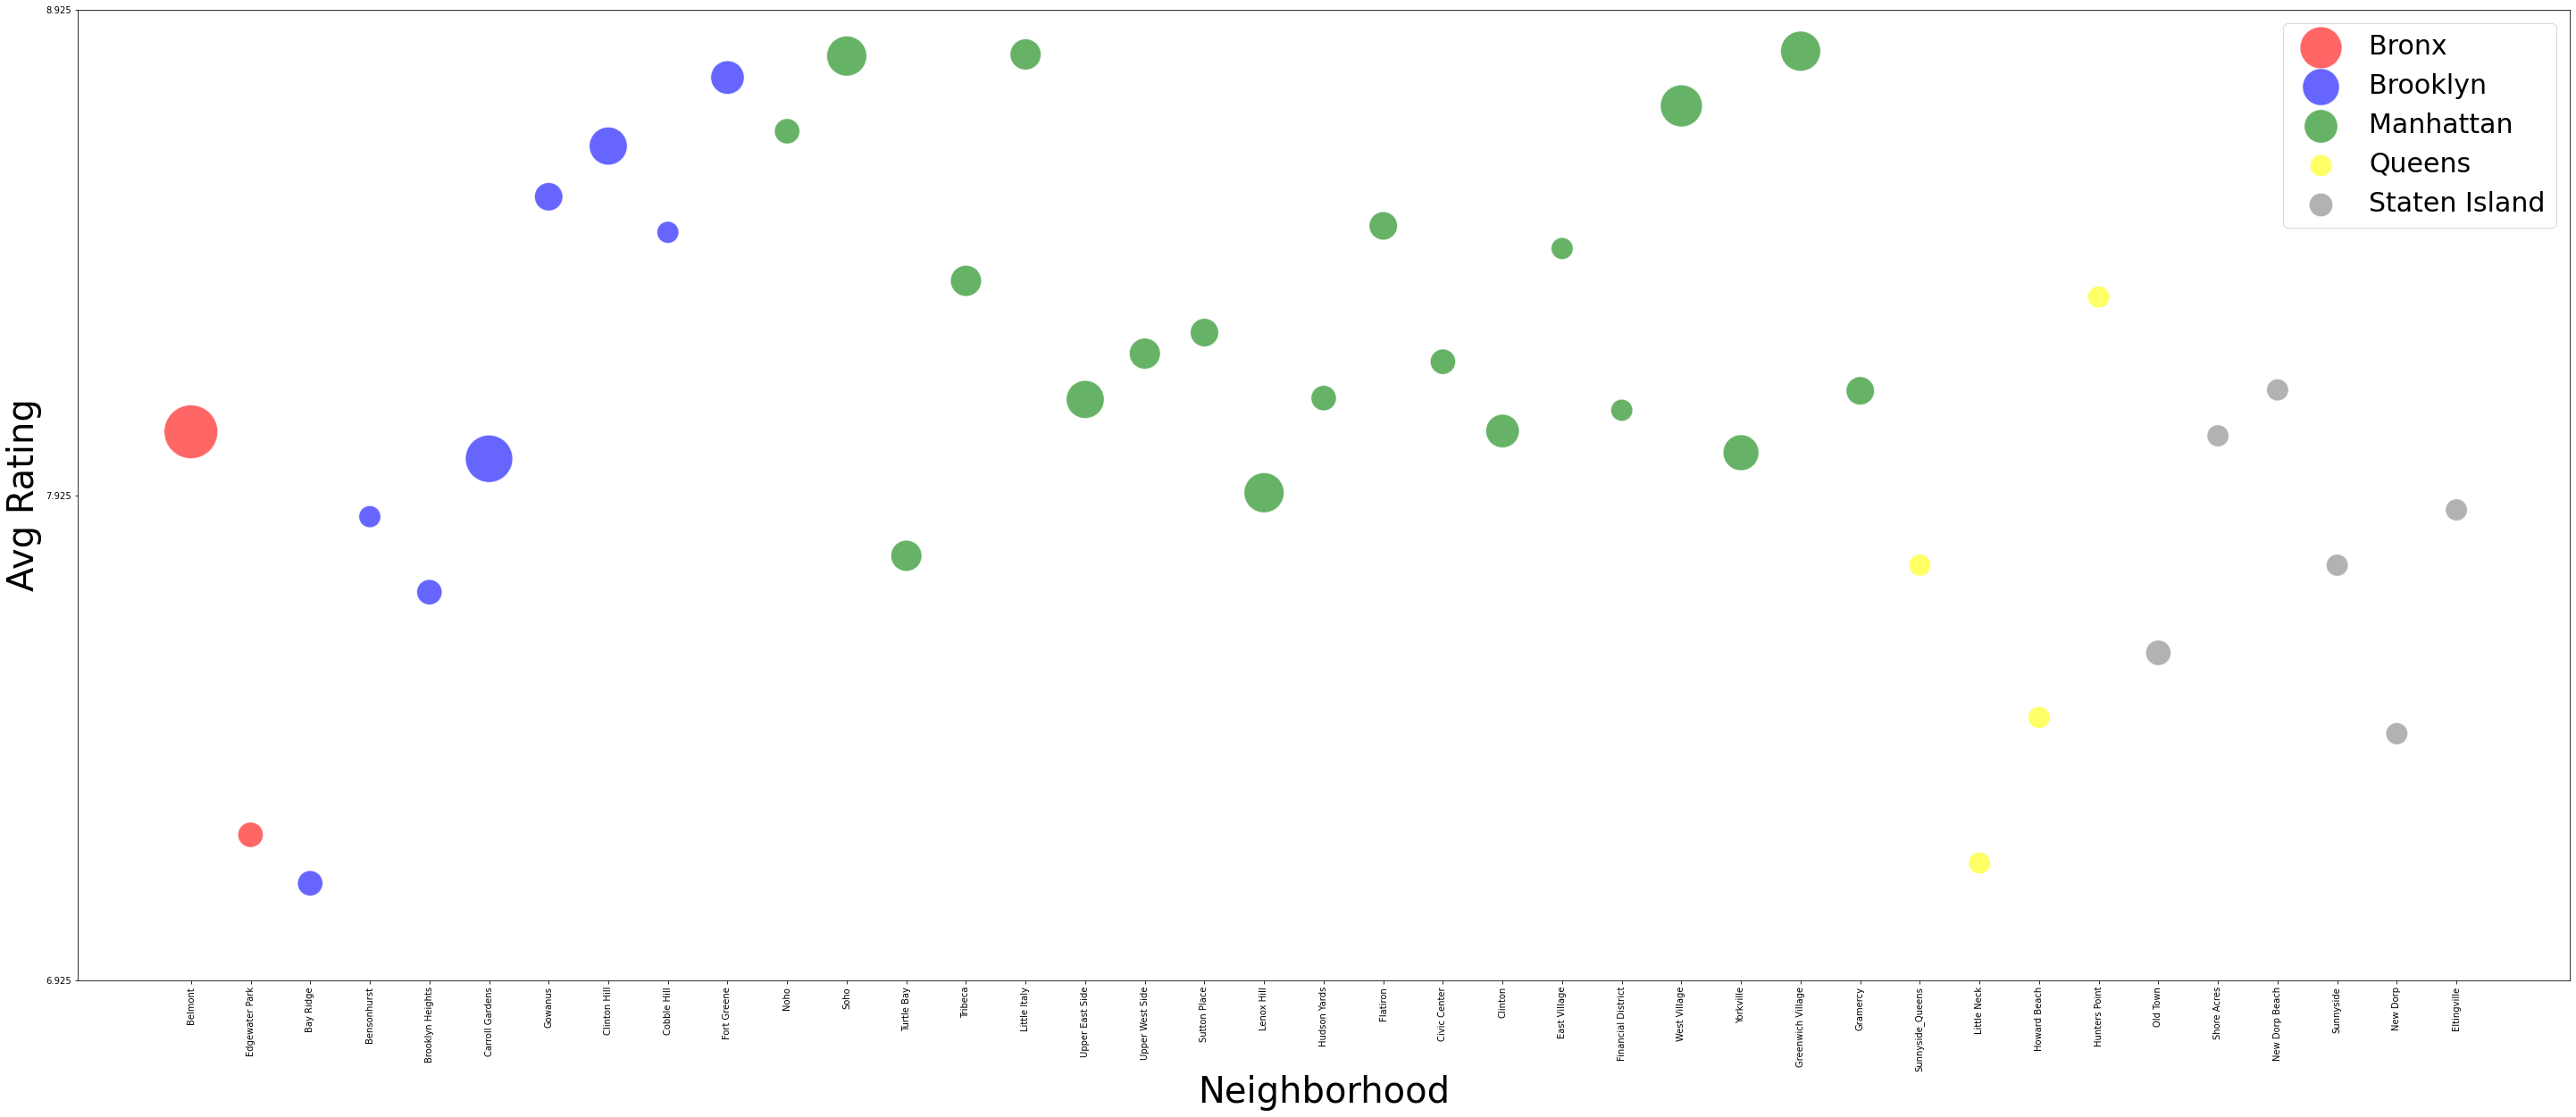

In [16]:
#PLOT BY RATINGS
rest_df.sort_values(by='Borough',inplace=True)
rest_df.loc[30,'Neighborhood'] = 'Sunnyside_Queens' #solving Sunnyside ambiguity

colors = {'Bronx':'red', 'Brooklyn':'blue', 'Manhattan':'green', 'Queens':'yellow', 'Staten Island':'grey'}
plt.figure(figsize=(50, 20))
for borough in rest_df['Borough'].unique():
#    
    neighborhoods = rest_df[rest_df['Borough']==borough]['Neighborhood']
    ratings = rest_df[rest_df['Borough']==borough]['Rating']    
    ratings_norm = ratings / rest_df[rest_df['Borough']==borough]['Rating'].max()
    
    plt.scatter(
        x = neighborhoods, 
        y = ratings, 
        s= rest_df[rest_df['Borough']==borough]['Restaurants']*200,#20000*ratings_norm**200, 
        c=colors[borough], 
        cmap="Accent", 
        alpha=0.6, 
        edgecolors="white", 
        linewidth=1);
plt.xlabel("Neighborhood", size=40)
plt.ylabel("Avg Rating", size=40)
plt.xticks(rest_df['Neighborhood'],labels=rest_df['Neighborhood'],rotation='vertical')
plt.yticks(np.arange(rest_df['Rating'].min()-0.2,rest_df['Rating'].max()+0.2,1))
plt.legend(rest_df['Borough'].unique(),loc="upper right", fontsize=30)
rest_df

### demo_df

In [17]:
#uploading csv dataset for demographic data
project = Project.access(None,'p-e75ea87462cfec9a00f843aabfee37718fe2dc29')

# Fetch the file
my_file = project.get_file("New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv")

# Read the CSV data file into a pandas DataFrame
my_file.seek(0)
demographic=pd.read_csv(my_file)

demographic.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population,Area,Density,IncomePerCap
0,Bronx,2010.0,5.0,BX01,Claremont-Bathgate,31078.0,16451870.90,529.37,10271.20244
1,Bronx,2010.0,5.0,BX03,Eastchester-Edenwald-Baychester,34517.0,40256794.22,1166.29,22059.31431
2,Bronx,2010.0,5.0,BX05,Bedford Park-Fordham North,54415.0,14998883.47,275.64,16710.63301
3,Bronx,2010.0,5.0,BX06,Belmont,27378.0,13556348.94,495.15,11806.76306
4,Bronx,2010.0,5.0,BX07,Bronxdale,35538.0,15185447.13,427.30,18643.02402


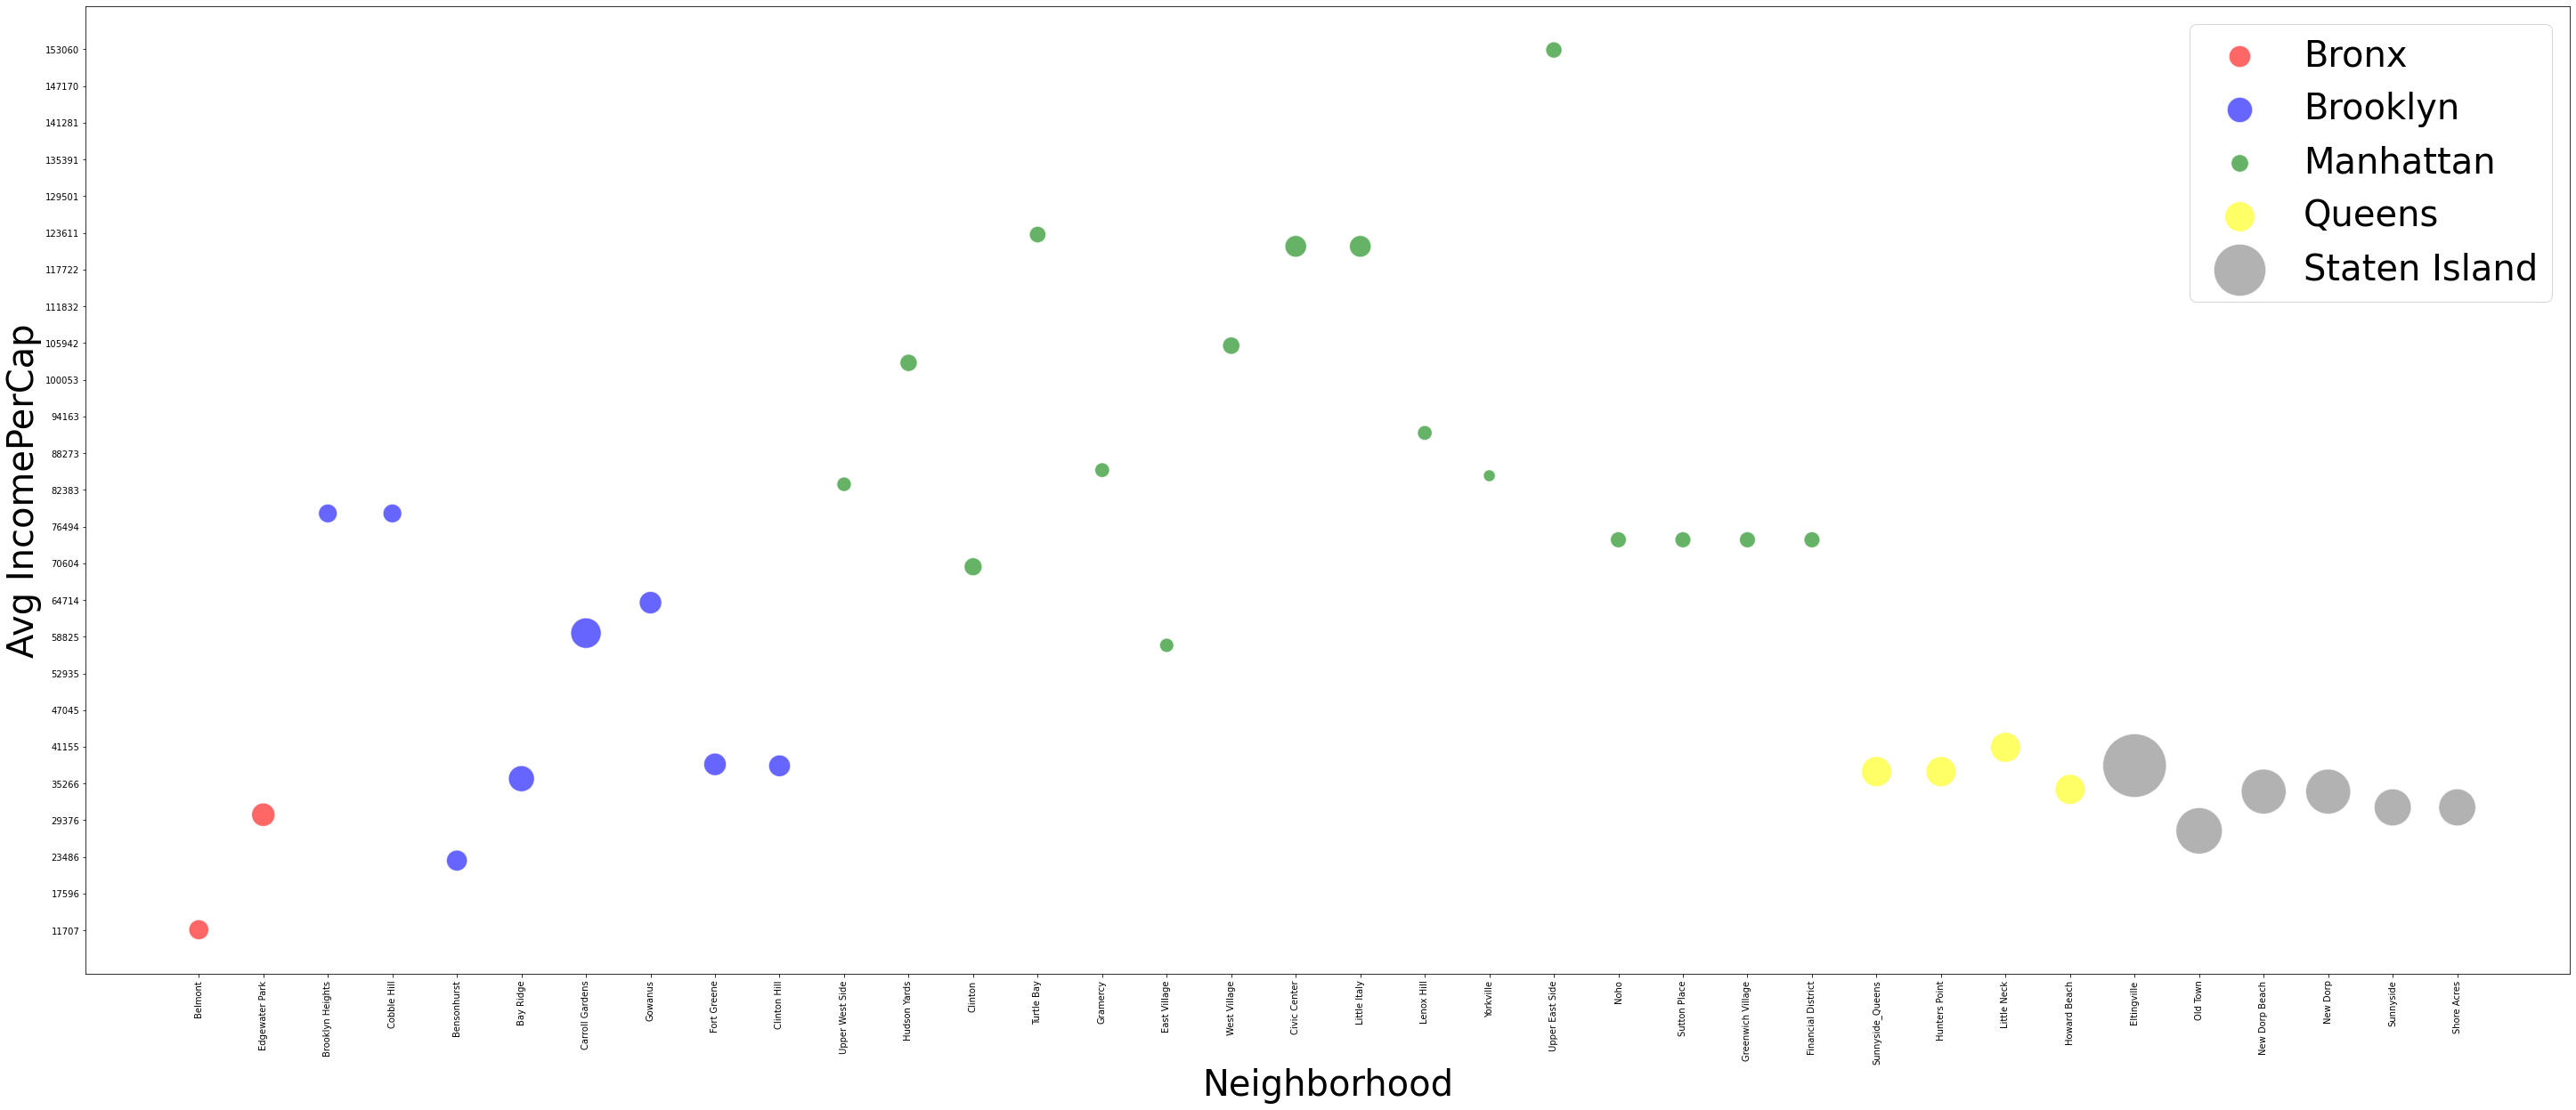

In [18]:
#Cleaning the dataset
#defining weighted_average

demo_df = pd.DataFrame()
demo_df['Borough'] = demographic['Borough']
demo_df['Neighborhood'] = demographic['NTA Name']
demo_df['PopByNeigh'] = demographic['Density']
demo_df['IncomePerCap'] = demographic['IncomePerCap']

means_pop = demo_df.groupby('Borough')['PopByNeigh'].mean()
means_inc = demo_df.groupby('Borough')['IncomePerCap'].mean()
for i in demo_df[demo_df['PopByNeigh'].isnull()].index:
    demo_df.loc[i, 'PopByNeigh'] = means_pop[demo_df.loc[i,'Borough']]
for i in demo_df[demo_df['IncomePerCap'].isnull()].index:
    demo_df.loc[i, 'IncomePerCap'] = means_inc[demo_df.loc[i,'Borough']]
                            

demo_df = pd.merge(demo_df,rest_df[['Neighborhood']],on='Neighborhood',how='inner')

colors = {'Bronx':'red', 'Brooklyn':'blue', 'Manhattan':'green', 'Queens':'yellow', 'Staten Island':'grey'}
plt.figure(figsize=(50, 20))
for borough in demo_df['Borough'].unique():
#    
    neighborhoods = demo_df[demo_df['Borough']==borough]['Neighborhood']
    IncomePerCaps = demo_df[demo_df['Borough']==borough]['IncomePerCap']    
    IncomePerCaps_norm = IncomePerCaps / demo_df[demo_df['Borough']==borough]['IncomePerCap'].max()
    
    plt.scatter(
        x = neighborhoods, 
        y = IncomePerCaps, 
        s= demo_df[demo_df['Borough']==borough]['PopByNeigh'],#20000*IncomePerCaps_norm**200, 
        c=colors[borough], 
        cmap="Accent", 
        alpha=0.6, 
        edgecolors="white", 
        linewidth=1);
plt.xlabel("Neighborhood", size=40)
plt.ylabel("Avg IncomePerCap", size=40)
plt.xticks(demo_df['Neighborhood'],labels=demo_df['Neighborhood'],rotation='vertical')
plt.yticks(np.linspace(demo_df['IncomePerCap'].min()-100,demo_df['IncomePerCap'].max()+100,25))
plt.legend(demo_df['Borough'].unique(),loc="upper right", fontsize=40)
#


## Model fitting and evaluation

In [33]:
#creating the final dataset for k-means clustering
kmeans_df = pd.merge(demo_df,rest_df[['Neighborhood','Rating','Restaurants']],on='Neighborhood',how='inner')
kmeans_df

#normalize and clean data
x = kmeans_df.iloc[:,[2,3,4,5]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)


#fitting the model
kclusters = 6 #let's try with 5 clusters
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(x_scaled)

#adding cluster to the dataset and discussion
kmeans_df.insert(0, 'Cluster Labels', kmeans.labels_)

kmeans_df.sort_values(by=('Cluster Labels'),ascending=True,inplace=True)
kmeans_df

,Cluster Labels,Borough,Neighborhood,PopByNeigh,IncomePerCap,Rating,Restaurants
32,0,Manhattan,Greenwich Village,315.728956,74375.850703,8.840000,10
8,0,Brooklyn,Fort Greene,632.030000,38346.210830,8.785714,7
9,0,Brooklyn,Clinton Hill,590.040000,38105.965150,8.644444,9
18,0,Manhattan,Little Italy,585.670000,121453.570000,8.833333,6
16,0,Manhattan,West Village,373.360000,105523.870000,8.727273,11
33,1,Manhattan,Financial District,315.728956,74375.850703,8.100000,3
3,1,Brooklyn,Cobble Hill,436.210000,78602.665130,8.466667,3
31,1,Manhattan,Sutton Place,315.728956,74375.850703,8.260000,5
30,1,Manhattan,Noho,315.728956,74375.850703,8.675000,4
7,1,Brooklyn,Gowanus,628.380000,64288.490110,8.540000,5


<BarContainer object of 6 artists>

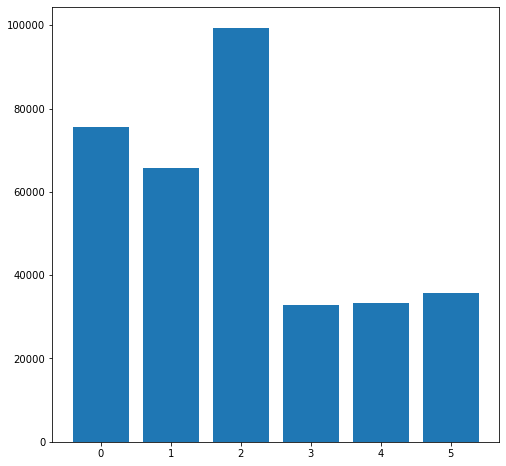

In [34]:
#final discussion
bar_data = kmeans_df.groupby('Cluster Labels').agg('mean').reset_index()
plt.figure(figsize=(8,8))
plt.bar(x='Cluster Labels',height='IncomePerCap',data=bar_data,tick_label=bar_data['Cluster Labels'])

<BarContainer object of 6 artists>

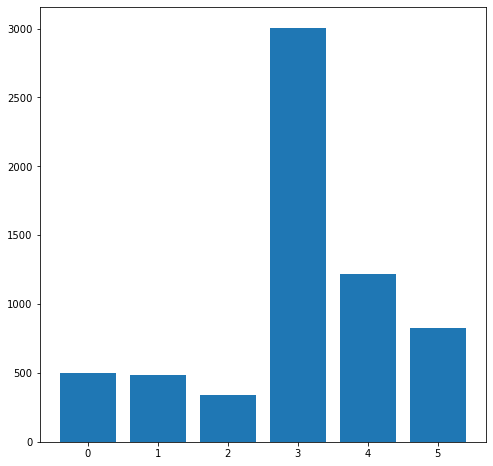

In [35]:
plt.figure(figsize=(8,8))
plt.bar(x='Cluster Labels',height='PopByNeigh',data=bar_data,tick_label=bar_data['Cluster Labels'])

<BarContainer object of 6 artists>

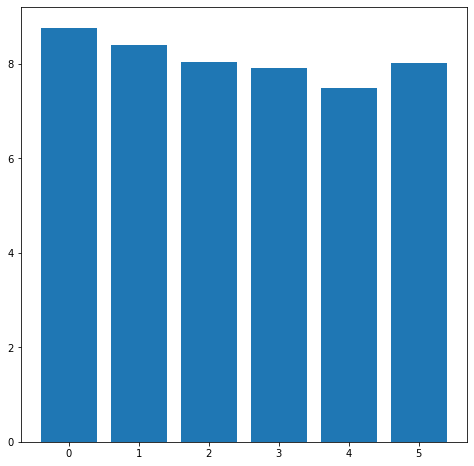

In [36]:
plt.figure(figsize=(8,8))
plt.bar(x='Cluster Labels',height='Rating',data=bar_data,tick_label=bar_data['Cluster Labels'])

<BarContainer object of 6 artists>

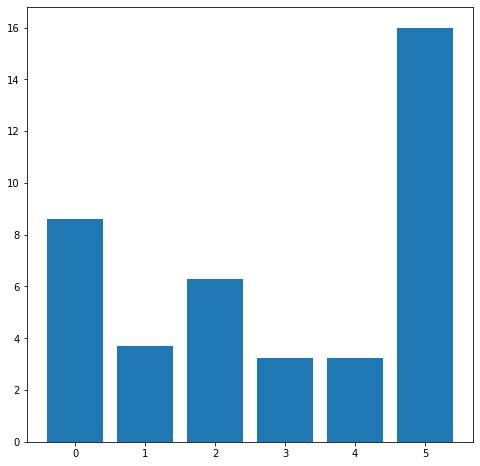

In [37]:
plt.figure(figsize=(8,8))
plt.bar(x='Cluster Labels',height='Restaurants',data=bar_data,tick_label=bar_data['Cluster Labels'])

In [38]:
bar_data

,Cluster Labels,PopByNeigh,IncomePerCap,Rating,Restaurants
0,0,499.365791,75561.093337,8.766153,8.600000
1,1,484.282876,65805.996476,8.401190,3.714286
2,2,342.873933,99418.312646,8.032853,6.300000
3,3,3006.484686,32808.099129,7.920942,3.250000
4,4,1214.579669,33401.737133,7.482319,3.250000
5,5,829.035000,35603.264730,8.027778,16.000000


In [39]:
#Visualization of the map of neighborhoods

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

kmeans_geo = pd.merge(kmeans_df,geo_df[['Neighborhood','Latitude','Longitude']],on='Neighborhood',how='inner')

colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'grey',5:'orange', 6:'brown', 7:'black'}
# add markers to map
for lat, lng, borough, neighborhood,cluster in zip(kmeans_geo['Latitude'], kmeans_geo['Longitude'], kmeans_geo['Borough'], kmeans_geo['Neighborhood'],kmeans_geo['Cluster Labels']):
    label = '{}, {}, {}'.format(neighborhood, borough,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Final Discussion

- **Income Per Cap** -: Clusters 0,1,2 offer a good opportunity in terms of income per cap, while clusters 3,4,5 seem to be less attractive
- **Density** -:Neighborhoods in Clusters 0,1 and 2 have a low population density while clusters 3,4,5 are the densest.
- **Rating** -:Rating is in average very similar between clusters. Cluster 4 seem to offer the best improvement opportunity, while cluster 0 identify neighborhood which already have the greatest Italian restaurants in NY.
- **N. Restaurants** -:Cluster 5 show the highest value and a big difference against all the others. Clusters 0 and 2 have an intermediate number of restaurants, while clusters 1,3,4 have the lowest.

The most attractive clusters of neighborhood seem to be **Cluster 2 and 5**.
In detail:
- **Cluster 2** - represent areas where to open an italian restaurant based on quality, raw material of first choice and high target of people. This because in those neighborhoods there is a low density of high-class population so the restaurant should be based on quality more than quantity. Moreover, the competition is middle level, this means that Italian Restaurants are quite appreciated but since the number of restaurants is mid, probably potential customers could prefer other cuisines. For this reason, I would suggest introducing some fusion cuisine elements in the menu in order to be more attractive in the market.
- **Cluster 5** - represent areas where to open an Italian restaurant more based on a fast and friendly service and with a business model based on high quantities and low prices. This because in this area there is a Mid density of low-class population so the restaurant should attract a lot of people taking also into account their economic power. Moreover, the competition shows a high number of Italian restaurants with mid average rating. This means that Italian cuisine is very appreciated in these neighborhoods but there are already a lot of appreciated venues. For this reason, I would suggest applying marketing strategies for customer retention and brand awareness (for example membership cards, “bring a friend” promo, social media marketing campaigns and so on).
